In [1]:
# Import library:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# Définition du chemin d'accès:
### Céline
# %cd C:\Users\c.doussot\Desktop\Data Analyst\GitHub\ParisPyVelib_Datas
### Hermine

### Tarik
%cd C:\Users\Home\Documents\Git\ParisPyVelib\Data

#Drive + Colab
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My Drive/Colab Notebooks/

C:\Users\Home\Documents\Git\ParisPyVelib\Data


- Une idée serait de faire la modélisation sur les comptages horaires moyen par jour et non par heure. Cela simplifiera le nombre de données et permettra d'intégrer facilement les données météos.

## Préparation des données

In [2]:
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')

In [3]:
# etendue des valeurs pour les na
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

In [4]:
# selection d'un seul compteur et uniquement pour l'année 2021
df = df[df.Address == "89 BD DE MAGENTA"]
df = df[df.Y_Date_Count == 2021 ]

# supression des colonnes non utile pour le modele
# df = df.drop(['Unnamed: 0', 'Coord', 'Coord_full', 'City_meteo', 'Latitude', 'Longitude', 'vacances_zone_c', 'Address', 
#               'Direction', 'Source', 'Id', 'Date_instal'], axis = 1)

df = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Address', 'Date',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal', 'H_Date_Count'], axis = 1)

# passage de la colonne date en datetime et passage en ms
# df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%dT%H:%M:%S')
# df['Date'] = df.Date.astype('int64') // 10**9      # réciproque : df['Date'] = pd.to_datetime(df['Date'], unit='s')

#split des colonne de date et heure
df[['Date','Time']] = df['Datetime'].str.split(' ',expand=True)
df = df.drop(['Date'], axis=1)
df[['hh','mm', 'ss' ]] = df['Time'].str.split(':',expand=True)
df = df.drop(['Time','Datetime', 'mm', 'ss'], axis=1)
df['hh'] = df.hh.astype('int64')

# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x < 12 else 'PM' for x in df['hh']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# reset de l'index
df = df.reset_index(drop=True)

# list des variable catégorielle
cat_df = df.select_dtypes(include='object')
cat_df = cat_df.columns.tolist()

# Transformation des variable catégorielle en variable indicatrices
df = pd.get_dummies(df, columns=cat_df)

# affichage des 5 première lignes du df
df.head()

,Count_by_hour,Latitude,Longitude,Y_Date_Count,M_Date_Count,D_Date_Count,Dweek_Date_Count,T°C,Precip_last3h,HR%,...,nom_vacances_Pont de l'Ascension,nom_vacances_Vacances d'hiver,nom_vacances_Vacances de Noël,nom_vacances_Vacances de printemps,Confinement_id_Confinement 3,Confinement_id_None,AM_PM_AM,AM_PM_PM,week_day_type_week,week_day_type_weekend
0,1.0,48.878,2.355,2021,1,1,4,1.1,0.0,92.0,...,0,0,1,0,0,1,1,0,1,0
1,6.0,48.878,2.355,2021,1,1,4,-0.4,0.0,96.0,...,0,0,1,0,0,1,1,0,1,0
2,5.0,48.878,2.355,2021,1,1,4,-0.4,0.0,96.0,...,0,0,1,0,0,1,1,0,1,0
3,7.0,48.878,2.355,2021,1,1,4,-0.4,0.0,96.0,...,0,0,1,0,0,1,1,0,1,0
4,6.0,48.878,2.355,2021,1,1,4,-1.9,0.0,98.0,...,0,0,1,0,0,1,1,0,1,0


In [5]:
# selection de la target et des feats
target = df['Count_by_hour']
feats = df.drop(['Count_by_hour'], axis=1)

In [6]:
# vérification du type des variables pour feats

feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Latitude                            3575 non-null   float64
 1   Longitude                           3575 non-null   float64
 2   Y_Date_Count                        3575 non-null   int64  
 3   M_Date_Count                        3575 non-null   int64  
 4   D_Date_Count                        3575 non-null   int64  
 5   Dweek_Date_Count                    3575 non-null   int64  
 6   T°C                                 3575 non-null   float64
 7   Precip_last3h                       3575 non-null   float64
 8   HR%                                 3575 non-null   float64
 9   High_ice                            3575 non-null   float64
 10  Wind_speed_mean10mn                 3575 non-null   float64
 11  hh                                  3575 no

In [7]:
# On récupère les valeurs de classes
pd.qcut(target, 4)
# [(-0.001, 19.0] < (19.0, 119.0] < (119.0, 227.0] < (227.0, 585.0]]

0       (-0.001, 19.0]
1       (-0.001, 19.0]
2       (-0.001, 19.0]
3       (-0.001, 19.0]
4       (-0.001, 19.0]
             ...      
3570    (227.0, 585.0]
3571    (227.0, 585.0]
3572    (119.0, 227.0]
3573     (19.0, 119.0]
3574     (19.0, 119.0]
Name: Count_by_hour, Length: 3575, dtype: category
Categories (4, interval[float64]): [(-0.001, 19.0] < (19.0, 119.0] < (119.0, 227.0] < (227.0, 585.0]]

In [8]:
target = pd.qcut(target, 4, labels = [0, 1, 2, 3])

In [9]:
# Séparation du jeux de donnée pour entrainement

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=101)

In [10]:
# preprocessing

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

## SVM

In [11]:
from sklearn import svm

# Création d'un classifieur clf sans paramètres
clf = svm.SVC()
# Entrainement de l'algorithme sur l'ensemble d'entrainement
clf.fit(X_train_scaled, y_train)

from sklearn import model_selection

# Recherche des meilleurs hyperparamètres

parametres = {'C':[0.1,1,10,50], 'kernel':['rbf','linear']}
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)
grille = grid_clf.fit(X_train_scaled,y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])
print('Le modèle qui fournit la meilleur prédiction à pour paramètres :',grid_clf.best_params_)

                           params  mean_test_score
0     {'C': 0.1, 'kernel': 'rbf'}         0.259790
1  {'C': 0.1, 'kernel': 'linear'}         0.567483
2       {'C': 1, 'kernel': 'rbf'}         0.259790
3    {'C': 1, 'kernel': 'linear'}         0.573776
4      {'C': 10, 'kernel': 'rbf'}         0.377972
5   {'C': 10, 'kernel': 'linear'}         0.561538
6      {'C': 50, 'kernel': 'rbf'}         0.442657
7   {'C': 50, 'kernel': 'linear'}         0.560490
Le modèle qui fournit la meilleur prédiction à pour paramètres : {'C': 1, 'kernel': 'linear'}


In [12]:
# Prédiction des features test et création de la matrice de confusion

clf = svm.SVC(C=1, kernel='linear')
clf.fit(X_train_scaled, y_train)

y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1,2,3
Classe réelle,,,,
0,142,22,0,7
1,43,89,26,12
2,7,67,65,51
3,11,35,36,102


Le modèle n'est pas satisfaisant pour obtenir une prédiction précise

## KNN

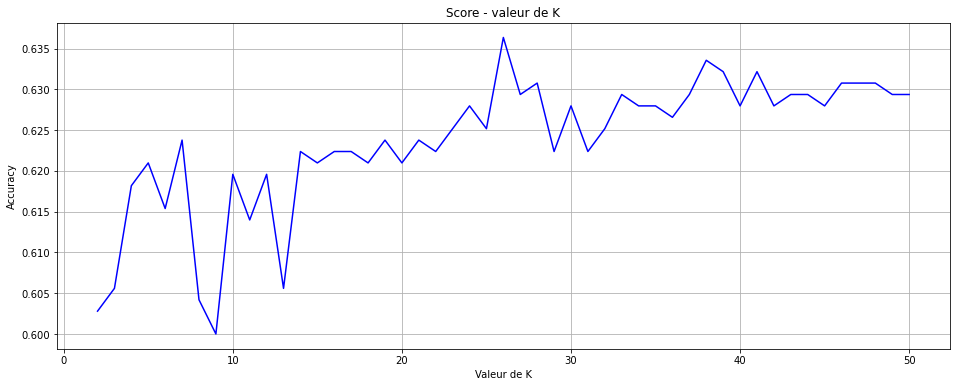

In [13]:
from sklearn import neighbors

score=[]

for k in range(2, 51):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score.append(knn.score(X_test_scaled, y_test))


plt.figure(figsize=(16,6))
plt.plot(range(2, 51), score, color='blue')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy')
plt.grid();

Précision meilleur que SVM mais pas assez précis pour avoir des prédiction correcte

## Random Forest

In [14]:
from sklearn import ensemble
from sklearn import model_selection

# Création d'un classifieur
clf = ensemble.RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [15]:
# parametres = {'max_features':["sqrt", "log2", None], 'min_samples_split':list(range(2, 32, 2))}
parametres = {'max_features':[None], 'min_samples_split':list(range(2, 32, 2))}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)

grille = grid_clf.fit(X_train_scaled,y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])
print('Le modèle qui fournit la meilleur prédiction à pour paramètres :',grid_clf.best_params_)

                                             params  mean_test_score
0    {'max_features': None, 'min_samples_split': 2}         0.821329
1    {'max_features': None, 'min_samples_split': 4}         0.825175
2    {'max_features': None, 'min_samples_split': 6}         0.821678
3    {'max_features': None, 'min_samples_split': 8}         0.822378
4   {'max_features': None, 'min_samples_split': 10}         0.822727
5   {'max_features': None, 'min_samples_split': 12}         0.823077
6   {'max_features': None, 'min_samples_split': 14}         0.825874
7   {'max_features': None, 'min_samples_split': 16}         0.822028
8   {'max_features': None, 'min_samples_split': 18}         0.826923
9   {'max_features': None, 'min_samples_split': 20}         0.823776
10  {'max_features': None, 'min_samples_split': 22}         0.829371
11  {'max_features': None, 'min_samples_split': 24}         0.825175
12  {'max_features': None, 'min_samples_split': 26}         0.818531
13  {'max_features': None, 'min_sa

In [16]:
# Prédiction des features test et création de la matrice de confusion

clf = ensemble.RandomForestClassifier(min_samples_split=14)
clf.fit(X_train_scaled, y_train)

y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1,2,3
Classe réelle,,,,
0,157,14,0,0
1,7,145,18,0
2,0,15,143,32
3,0,0,29,155


Le modèle à une meilleur précision > 80% pour le moment c'est suffisant

## Prédiction avec Random Forest

In [17]:
import ipywidgets as widgets
from IPython.display import display

Month = widgets.IntSlider(value=2,
    min=1,
    max=12,
    step=1,
    description='Month :',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d', layout=widgets.Layout(width='100%'))

Day = widgets.IntSlider(value=2,
    min=1,
    max=31,
    step=1,
    description='Day :',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d', layout=widgets.Layout(width='100%'))

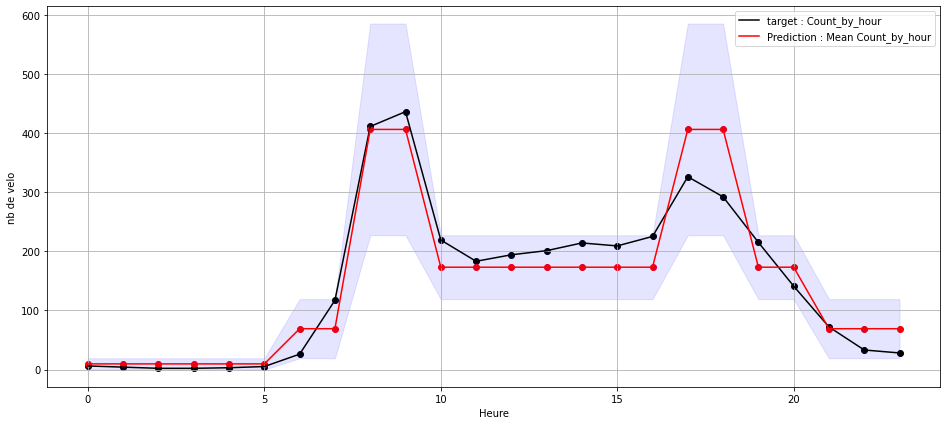

In [18]:
# selection de la date
df_Select = df[df.M_Date_Count == Month.value]
df_Select = df_Select[df_Select.D_Date_Count == Day.value]

# selection de la target et des feats
target_to_predict = df_Select['Count_by_hour']
feats_to_predict = df_Select.drop(['Count_by_hour'], axis=1)

# Calul des prédiction
prediction = clf.predict(feats_to_predict)

# création d'une liste avec les moyennes des classes et remplacement des moyennes dans le resultat des prédictions
lmc = [9.5, 69, 173, 406]
lmin = [0, 19, 119, 227]
lmax = [19, 119, 227, 585]
pred = []
pred_min = []
pred_max = []

for classes in prediction:
    if classes == 0:
        pred.append(lmc[0])
        pred_min.append(lmin[0])
        pred_max.append(lmax[0])
    if classes == 1:
        pred.append(lmc[1])
        pred_min.append(lmin[1])
        pred_max.append(lmax[1])
    if classes == 2:
        pred.append(lmc[2])
        pred_min.append(lmin[2])
        pred_max.append(lmax[2])
    if classes == 3:
        pred.append(lmc[3]) 
        pred_min.append(lmin[3])
        pred_max.append(lmax[3])
        
# Graphique du compteur et des prédiction      
plt.figure(figsize=(16,7))
# graph du compteur horaire
plt.plot(df_Select['hh'],df_Select['Count_by_hour'],color='black')
plt.scatter(df_Select['hh'],df_Select['Count_by_hour'],color='black')
# graph des prédiction
plt.plot(df_Select['hh'], pred, color='red')
plt.scatter(df_Select['hh'], pred, color='red')

plt.fill_between(df_Select['hh'], pred_min, pred_max, alpha=0.1, color="blue")

plt.xlabel('Heure')
plt.ylabel('nb de velo')
plt.legend(['target : Count_by_hour', 'Prediction : Mean Count_by_hour'])

plt.grid();

In [19]:
display(Month, Day)

IntSlider(value=2, continuous_update=False, description='Month :', layout=Layout(width='100%'), max=12, min=1)

IntSlider(value=2, continuous_update=False, description='Day :', layout=Layout(width='100%'), max=31, min=1)

## Conclusion : 

Le modèle ramdom forest nous donnes des performances de prédiction satisfaisante.